**Sentetik data seti oluşturulması**

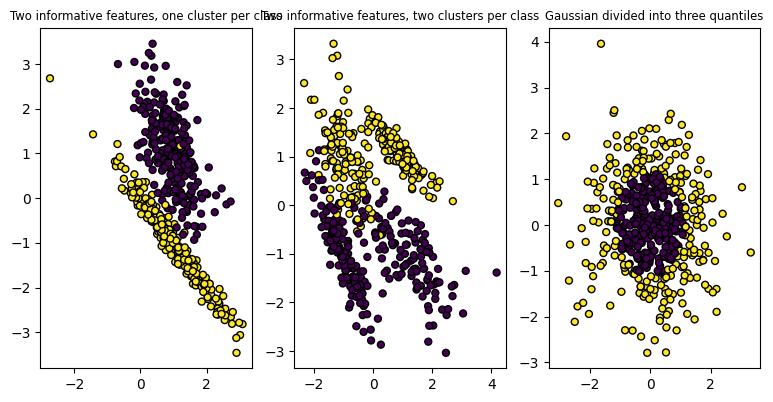

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
plt.figure(figsize=(8, 4))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)


plt.subplot(131)
plt.title("Two informative features, one cluster per class", fontsize='small')
X1, Y1 = make_classification(n_samples=500,n_features=2,random_state=1, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k')

plt.subplot(132)
plt.title("Two informative features, two clusters per class",
          fontsize='small')
X2, Y2 = make_classification(n_samples=500,random_state=1, n_features=2,
                             n_redundant=0,
                             n_informative=2)
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2,
            s=25, edgecolor='k')


plt.subplot(133)
plt.title("Gaussian divided into three quantiles", fontsize='small')
X3, Y3 = make_gaussian_quantiles(n_samples=500,random_state=1,n_features=2, n_classes=2)
plt.scatter(X3[:, 0], X3[:, 1], marker='o', c=Y3,
            s=25, edgecolor='k')

plt.show()  # various graphs

In [13]:
# 1. dataset için eğitim ve test setlerinin oluşturulması
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.33, random_state=42)

# 2. dataset için eğitim ve test setlerinin oluşturulması
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.33, random_state=42)

# 3. dataset için eğitim ve test setlerinin oluşturulması
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.33, random_state=42)

**Model kodları**

*MLP MODELİ*

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

def initialize_weights(layer_sizes, initialization='xavier'):
    weights = []
    biases = []
    for i in range(1, len(layer_sizes)):
        if initialization == 'xavier':
            weight = np.random.randn(layer_sizes[i], layer_sizes[i - 1]) * np.sqrt(1 / layer_sizes[i - 1])
        elif initialization == 'he':
            weight = np.random.randn(layer_sizes[i], layer_sizes[i - 1]) * np.sqrt(2 / layer_sizes[i - 1])
        else:
            weight = np.random.randn(layer_sizes[i], layer_sizes[i - 1]) * 0.01
        bias = np.zeros((layer_sizes[i], 1))
        weights.append(weight)
        biases.append(bias)
    return weights, biases

def forward_propagation(X, weights, biases):
    A = X.T
    cache = {'A0': A}
    L = len(weights)
    for l in range(L):
        Z = np.dot(weights[l], A) + biases[l]
        A = sigmoid(Z)
        cache[f'Z{l+1}'] = Z
        cache[f'A{l+1}'] = A
    return A, cache

def compute_loss(Y, A):
    m = Y.shape[0]
    loss = -1 / m * np.sum(Y * np.log(A.T) + (1 - Y) * np.log(1 - A.T))
    return loss

def backward_propagation(X, Y, weights, biases, cache):
    m = X.shape[0]
    grads = {}
    L = len(weights)
    A_final = cache[f'A{L}']
    dA = - (np.divide(Y, A_final.T) - np.divide(1 - Y, 1 - A_final.T)).T
    for l in reversed(range(L)):
        dZ = dA * sigmoid_derivative(cache[f'Z{l+1}'])
        dW = 1 / m * np.dot(dZ, cache[f'A{l}'].T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        if l > 0:
            dA = np.dot(weights[l].T, dZ)
        grads[f'dW{l+1}'] = dW
        grads[f'db{l+1}'] = db
    return grads

def update_parameters(weights, biases, grads, learning_rate):
    L = len(weights)
    for l in range(L):
        weights[l] -= learning_rate * grads[f'dW{l+1}']
        biases[l] -= learning_rate * grads[f'db{l+1}']
    return weights, biases

def train_mlp(X_train, Y_train, layer_sizes, epochs=1000, learning_rate=0.01, initialization='xavier'):
    weights, biases = initialize_weights(layer_sizes, initialization)
    for epoch in range(epochs):
        A, cache = forward_propagation(X_train, weights, biases)
        loss = compute_loss(Y_train, A)
        grads = backward_propagation(X_train, Y_train, weights, biases, cache)
        weights, biases = update_parameters(weights, biases, grads, learning_rate)
    return weights, biases

def predict_mlp(X, weights, biases):
    A, _ = forward_propagation(X, weights, biases)
    predictions = (A > 0.5).astype(int).T
    return predictions

*SVM MODELİ*

In [15]:
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    dw = 2 * self.lambda_param * self.w
                    self.w -= self.learning_rate * dw
                else:
                    dw = 2 * self.lambda_param * self.w - np.dot(y_[idx], x_i)
                    db = y_[idx]
                    self.w -= self.learning_rate * dw
                    self.b -= self.learning_rate * db

    def predict(self, X):
        linear_output = np.dot(X, self.w) - self.b
        return np.sign(linear_output)

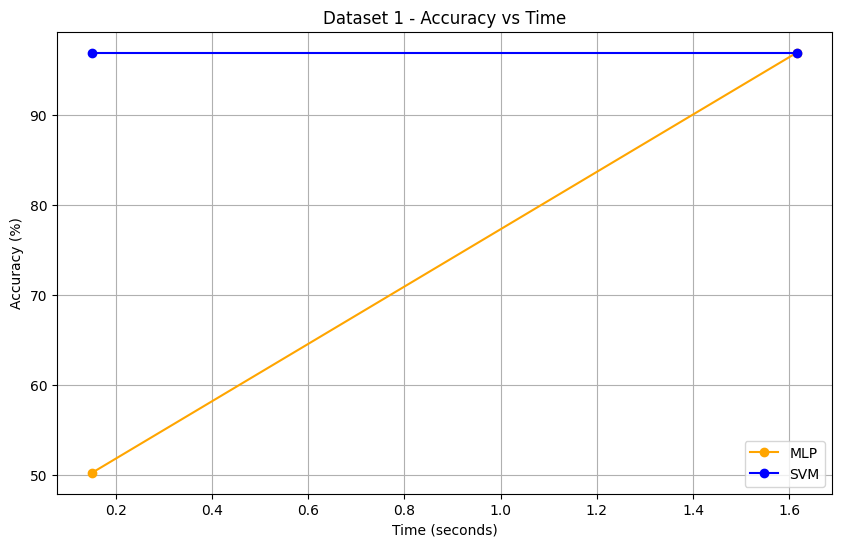

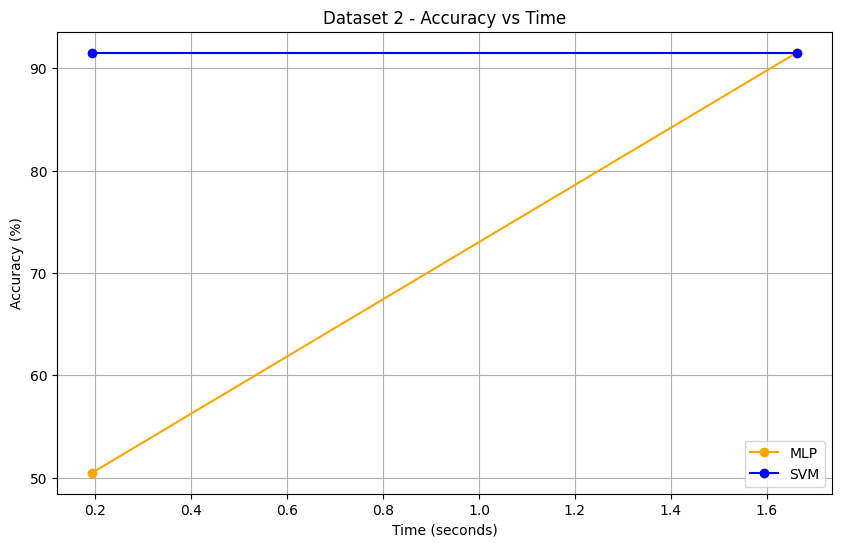

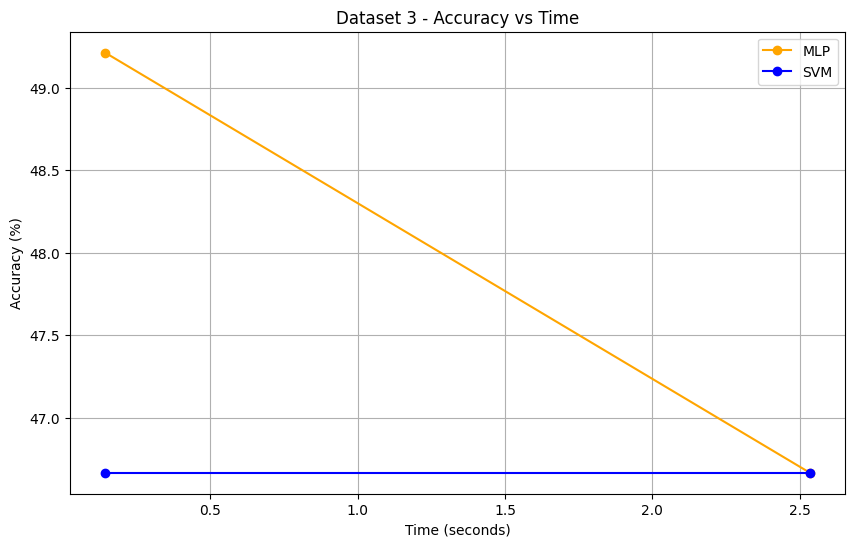

In [24]:
import pandas as pd

for dataset_id in results_df['dataset']:
    plt.figure(figsize=(10, 6))
    plt.plot(
    [results_df.loc[results_df['dataset'] == dataset_id, 'mlp_time'].values[0],
    results_df.loc[results_df['dataset'] == dataset_id, 'svm_time'].values[0]],
    [results_df.loc[results_df['dataset'] == dataset_id, 'mlp_accuracy'].values[0],
    results_df.loc[results_df['dataset'] == dataset_id, 'svm_accuracy'].values[0]],
    label='MLP', marker='o', color='orange'
)
    plt.plot(
    [results_df.loc[results_df['dataset'] == dataset_id, 'mlp_time'].values[0],
    results_df.loc[results_df['dataset'] == dataset_id, 'svm_time'].values[0]],
    [results_df.loc[results_df['dataset'] == dataset_id, 'svm_accuracy'].values[0],
    results_df.loc[results_df['dataset'] == dataset_id, 'svm_accuracy'].values[0]],
    label='SVM', marker='o', color='blue'
)
    plt.title(f'Dataset {dataset_id} - Accuracy vs Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

